## Text Classification with scikit-learn

## We will base the code off 
http://scikit-learn.org/stable/auto_examples/applications/plot_out_of_core_classification.html#sphx-glr-auto-examples-applications-plot-out-of-core-classification-py

This video is about when the data doesn't fit in memory. We will use the same data as before so that we can make salient the differences between the two approaches

## License Information (since basing it off code by E. Diemert)

Modification of code at http://scikit-learn.org/stable/auto_examples/applications/plot_out_of_core_classification.html#sphx-glr-auto-examples-applications-plot-out-of-core-classification-py

Authors: Eustache Diemert <eustache@diemert.fr>
          @FedericoV <https://github.com/FedericoV/>
License: BSD 3 clause

Copyright (c) Eustache Diemert, All rights reserved.

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

* Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.
* Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.
* Neither the name of the copyright holder nor the names of its contributors may be used to endorse or promote products derived from this software without specific prior written permission. 

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

In [1]:
# First lets get the data like we did before
# http://scikit-learn.org/stable/datasets/twenty_newsgroups.html#newsgroups
from sklearn.datasets import fetch_20newsgroups
texts = fetch_20newsgroups(subset='train')
dir(texts)

['DESCR', 'data', 'description', 'filenames', 'target', 'target_names']

In [50]:
import re
import random
import collections

from os import listdir

from nltk.corpus import stopwords
from string import punctuation

from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer(language='english', ignore_stopwords=True)

In [66]:
doc_path = 'C:\\Users\\Artur_Zahreba\\Desktop\\WorkFusion\\P&G\\sample email June 15\\DocsTxt'

doc_types = sorted(listdir(doc_path))

doc_texts = []

for doc_type in doc_types:
    filenames = sorted(listdir(doc_path + '\\' + doc_type))
    filenames = filter(lambda x: re.search(r'\.txt$', x), filenames)
    for filename in filenames:
        with open(doc_path + '\\' + doc_type + '\\' + filename, 'r') as ffile:
            txt = ffile.read()
            doc_texts.append((doc_type, filename, txt))
            ffile.close()

random.shuffle(doc_texts)            
lables, _, texts = zip(*doc_texts)
texts = (texts)

lable_dict = dict(zip(list(set(lables)), range(len(set(lables)))))

lables_int = list(map(lambda x: lable_dict[x], lables))

txts_tpl = collections.namedtuple('txts_tpl',['data','target_names','target'])
texts = txts_tpl(texts, lables, lables_int)

print(len(texts.target))

194


In [67]:
# Define a get minibatch that returns just a little of the data at a time
# If storing the data on disk, data_idx could be a file pointer

BATCH_SIZE = 32
# data_idx - pointer to current record
# texts - dataset

def get_batch(data_idx, texts):
    # Need it as a list of x and a list of y
    data_x, data_y = [],[]
    for t in range(BATCH_SIZE):
        # We will loop through the data multiple times
        if data_idx == len(texts.data):
            return [], [], 0
        data_x.append(texts.data[data_idx])
        data_y.append(texts.target[data_idx])
        data_idx += 1
    return data_x, data_y, data_idx

# start with index 0
data_idx = 0

In [68]:
import numpy as np

from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB

In [69]:
# Uses hashing trick: Instead of creating a dictionary and associating each
# word with an index i, the index for a word w is computed using a hashing
# function h. i = h(w) mod n_features
vectorizer = HashingVectorizer(decode_error='ignore', n_features=2 ** 18,
                               non_negative=True)

In [70]:
# number of classes
all_classes = np.array(range(2))

In [71]:
# Let's try four different classifiers
partial_fit_classifiers = {
    'SGD': SGDClassifier(), # An SVM
    'Perceptron': Perceptron(),
    'NB Multinomial': MultinomialNB(alpha=0.01), # ignores non-occuring features
    'Passive-Aggressive': PassiveAggressiveClassifier(), # for large-scale learning
}

In [72]:
# First we hold out a number of examples to estimate accuracy
n_test_documents = BATCH_SIZE
X_test_text = []
y_test = []
for i in range(6):
    _X_test_text, _y_test, data_idx = get_batch(data_idx, texts)
    X_test_text.extend(_X_test_text)
    y_test.extend((_y_test))

In [73]:
# Convert the test data into features    
X_test = vectorizer.transform(X_test_text)

In [74]:
# Create some structure to store statistics
def progress(cls_name, stats):
    """Report progress information, return a string."""
    s = "%20s classifier : \t" % cls_name
    s += "accuracy: %(accuracy).3f " % stats
    return s

cls_stats = {}
for cls_name in partial_fit_classifiers:
    stats = {'n_train': 0, 'n_train_pos': 0,
             'accuracy': 0.0, 'accuracy_history': [(0, 0)]}
    cls_stats[cls_name] = stats

In [75]:
# Main loop : iterate on mini-batches of examples
X_train_text, y_train, data_idx = get_batch(data_idx, texts)

loop_count = 0
while len(X_train_text) > 0:
    
    loop_count += 1
    
    # vectorize train data
    X_train = vectorizer.transform(X_train_text)

    for cls_name, cls in partial_fit_classifiers.items():

        # update estimator with examples in the current mini-batch
        cls.partial_fit(X_train, y_train, classes=all_classes)

        # accumulate test accuracy stats
        cls_stats[cls_name]['n_train'] += X_train.shape[0]
        cls_stats[cls_name]['n_train_pos'] += sum(y_train)
        cls_stats[cls_name]['accuracy'] = cls.score(X_test, y_test)
        acc_history = (cls_stats[cls_name]['accuracy'],
                       cls_stats[cls_name]['n_train'])
        cls_stats[cls_name]['accuracy_history'].append(acc_history)

        if loop_count % 3 == 0:
            print(progress(cls_name, cls_stats[cls_name]))
    if loop_count % 3 == 0:
        print('\n')
        
    X_train_text, y_train, data_idx = get_batch(data_idx, texts)
        
# Getting divide by 0 because in some calls not all classes are represented
# http://stackoverflow.com/questions/32697093/errors-encountered-in-partial-fit-in-scikit-learn

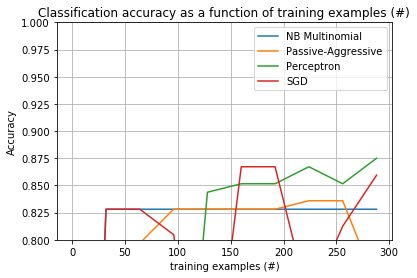

In [65]:
%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib import rcParams

def plot_accuracy(x, y, x_legend):
    """Plot accuracy as a function of x."""
    x = np.array(x)
    y = np.array(y)
    plt.title('Classification accuracy as a function of %s' % x_legend)
    plt.xlabel('%s' % x_legend)
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.plot(x, y)

rcParams['legend.fontsize'] = 10
cls_names = list(sorted(cls_stats.keys()))

# Plot accuracy evolution
plt.figure()
for _, stats in sorted(cls_stats.items()):
    # Plot accuracy evolution with #examples
    accuracy, n_examples = zip(*stats['accuracy_history'])
    plot_accuracy(n_examples, accuracy, "training examples (#)")
    ax = plt.gca()
    ax.set_ylim((0.8, 1))
plt.legend(cls_names, loc='best')

